In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

from functools import partial

import param_scan


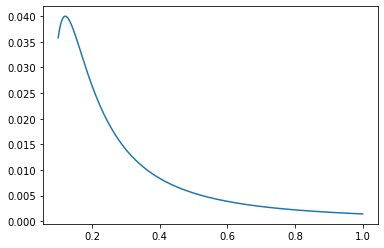

In [168]:
# Test the probabilities
theta = {"g": 1, "m4": np.sqrt(0.3), "Ue4Sq": 1e-1, "Um4Sq": 1e-1}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=False)
# sterile.Ldec(0.2)
# sterile.Losc(0.3)
E = np.linspace(0.1, 1, 1000)
L = 0.5
plt.plot(E, sterile.Pme(E,E,L))

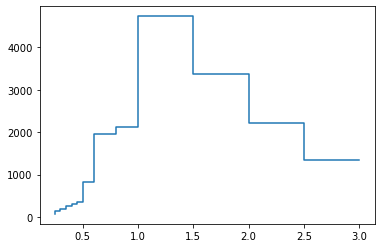

In [12]:
# NuE spectra as a function of true energy, w/o and w/ new physics.
MuB_True_BinEdges = [
    0.200,
    0.250,
    0.300,
    0.350,
    0.400,
    0.450,
    0.500,
    0.600,
    0.800,
    1.000,
    1.500,
    2.000,
    2.500,
    3.000,
]
MCT = [77.71578947, 143.90340557, 196.07832817, 267.13560372, 327.16160991,
  373.37368421, 894.8247678, 2112.43839009, 2272.64024768, 5099.22910217,
3630.38080495, 2404.02167183, 1456.92260062]
theta = {"g": 1, "m4": 100, "Ue4Sq": 1e-1, "Um4Sq": 5e-1}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=True)
# sterile.Ldec(0.2)
# sterile.Losc(0.3)
Ebin = np.linspace(0, 3, 51)
L = 0.5
PeeRW = []
PeeRW_deg = np.zeros((len(MCT), len(MCT)))
PeeRW_osc = []
# degradation piece
for k in range(len(MCT)):
    for i in range(k + 1):
        Peedecay = sterile.Peedecay(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], MuB_True_BinEdges[i + 1], L)
        PeeRW_deg[k][i] = Peedecay * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i])
PeeRW_sum = np.sum(PeeRW_deg, axis=0)

# oscillation piece
for i in range(len(MCT)):
    Peeosc = sterile.Peeosc(MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L)
    PeeRW_osc.append(Peeosc * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))

# Normalize MCT-event rate/GeV
MCT_norm = []
for i in range(len(MCT)):
    MCT_norm.append(MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))
PeeRW = PeeRW_sum + PeeRW_osc



#PeeRW_unnorm = sterile.EnergyDegradation(MCT, MuB_True_BinEdges, 'Pee')
#plt.step(MuB_True_BinEdges[1:], MCT_norm)
plt.step(MuB_True_BinEdges[1:], PeeRW)
plt.step(MuB_True_BinEdges[1:], PeeRW_unnorm)
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum1, label = 'n = 1 (default)')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum2, label = 'n = 2')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum3, label = 'n = 3')
#plt.xlabel('True energy(GeV)')
#plt.ylabel('Events/GeV')
#plt.title('NuE spectrum (decay term) with different degradation power(n)')
#plt.legend()

#plt.step(MuB_True_BinEdges[1:], PeeRW_osc)
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[5])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[7])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[9])

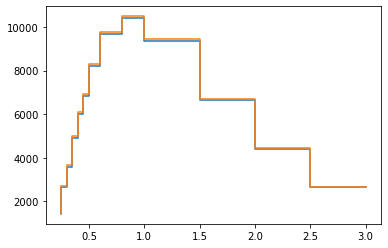

In [305]:
# NuE spectra w/ and w/o energy degradation
PeeRW_old = []
for k in range(len(MCT)):
    RWFact = sterile.PeeAvg(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], L)
    PeeRW_old.append(MCT[k] * RWFact / (MuB_True_BinEdges[k + 1] - MuB_True_BinEdges[k]))
plt.step(MuB_True_BinEdges[1:], PeeRW_old)
plt.step(MuB_True_BinEdges[1:], PeeRW)

## Run some scans

In [20]:
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

### 2D scans

De Gouvea's case

In [10]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 10

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.9, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=y_Vec, Ue4Sq=1e-1, Um4Sq=x_Vec)

func_2Dscan_deGouvea = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=False, decay=True, decouple_decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_deGouvea, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_deGouvea", res)

Pure oscillation case

In [32]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 10

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.9, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=0.1, m4=y_Vec, Ue4Sq=1e-2, Um4Sq=x_Vec)

# Pure oscillation method
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.1", res)

In [6]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 3

# Range of gm4 for sterile decay model scanned over 0.1 to 1000
gm_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=gm_Vec, Ue4Sq=e_Vec, Um4Sq=mu_Vec)

# Pure oscillation method
func_3Dscan_decay = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_3Dscan_decay, paramlist_decay)
np.save(f"{path_results}/App_gm4_Ue4sq_Um4sq_test", res)

In [ ]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 4-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of gm4 for sterile decay model scanned over 0.1 to 1000
g_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of m4 for sterile decay model scanned over 10 to 1000 eV
m_Vec = np.geomspace(1e1, 1e3, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=g_Vec, m4=m_Vec, Ue4Sq=e_Vec, Um4Sq=mu_Vec)

# Pure oscillation method
func_3Dscan_decay = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_3Dscan_decay, paramlist_decay)
np.save(f"{path_results}/App_g_m4_Ue4sq_Um4sq_v1", res)

### Deprecated

THis code needs to adapted to the method above.

In [73]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of gm4 for sterile decay model scanned over 0.1 to 100
gm_Vec = np.geomspace(1e-1, 1e3, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, e_Vec, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/App_gm4_Ue4sq_Um4sq_migrated_v3_15*15*15", res)

[[1.00000000e-01 1.00000000e-04 1.00000000e-04]
 [1.00000000e-01 1.83478607e-04 1.00000000e-04]
 [1.00000000e-01 3.36643992e-04 1.00000000e-04]
 ...
 [1.00000000e+05 1.45554357e-01 4.90000000e-01]
 [1.00000000e+05 2.67061108e-01 4.90000000e-01]
 [1.00000000e+05 4.90000000e-01 4.90000000e-01]]


In [72]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
gm_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, 1e-1, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/Fixed_Ue4sq_1e-2_15*15_v3", res)

[[1.00000000e-01 1.00000000e-01 1.00000000e-04]
 [1.63789371e-01 1.00000000e-01 1.00000000e-04]
 [2.68269580e-01 1.00000000e-01 1.00000000e-04]
 [4.39397056e-01 1.00000000e-01 1.00000000e-04]
 [7.19685673e-01 1.00000000e-01 1.00000000e-04]
 [1.17876863e+00 1.00000000e-01 1.00000000e-04]
 [1.93069773e+00 1.00000000e-01 1.00000000e-04]
 [3.16227766e+00 1.00000000e-01 1.00000000e-04]
 [5.17947468e+00 1.00000000e-01 1.00000000e-04]
 [8.48342898e+00 1.00000000e-01 1.00000000e-04]
 [1.38949549e+01 1.00000000e-01 1.00000000e-04]
 [2.27584593e+01 1.00000000e-01 1.00000000e-04]
 [3.72759372e+01 1.00000000e-01 1.00000000e-04]
 [6.10540230e+01 1.00000000e-01 1.00000000e-04]
 [1.00000000e+02 1.00000000e-01 1.00000000e-04]
 [1.00000000e-01 1.00000000e-01 1.83478607e-04]
 [1.63789371e-01 1.00000000e-01 1.83478607e-04]
 [2.68269580e-01 1.00000000e-01 1.83478607e-04]
 [4.39397056e-01 1.00000000e-01 1.83478607e-04]
 [7.19685673e-01 1.00000000e-01 1.83478607e-04]
 [1.17876863e+00 1.00000000e-01 1.834786

In [69]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 4-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

m4 = 1e3

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 0.5 in 15 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of g for sterile decay model scanned over 0.1 to 100 in 15 steps
g_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 0.5 in 15 steps
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(g_Vec, m4, e_Vec, mu_Vec)).T.reshape(-1, 4)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_4D, paramlist_decay)
np.save(f"{path_results}/Fixed_m4_1e3_15*15*15_v1", res)

[[1.00000000e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [1.63789371e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [2.68269580e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 ...
 [3.72759372e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [6.10540230e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [1.00000000e+02 1.00000000e+03 4.90000000e-01 4.90000000e-01]]
